In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from sklearn.impute import KNNImputer
import warnings
import pickle
warnings.filterwarnings('ignore')


In [2]:
def load_data(filepath):
    """
    Load the Pima Indians Diabetes dataset.
    
    Args:
        filepath (str): Path to the CSV file
        
    Returns:
        pd.DataFrame: Loaded dataset
    """
    print("=" * 80)
    print("STEP 1: LOADING DATA")
    print("=" * 80)
    
    df = pd.read_csv(filepath)
    
    print("✓ Dataset loaded successfully")
    print(f"✓ Shape: {df.shape[0]} samples, {df.shape[1]} features")
    print("\nColumn names:\n", df.columns.tolist())
    print("\nData types:\n", df.dtypes)
    print("\nFirst few rows:\n", df.head())
    
    return df


In [3]:
filepath = r"D:\Dhanvantari.ai\models\Diabetes\diabetes.csv"

df = load_data(filepath)


STEP 1: LOADING DATA
✓ Dataset loaded successfully
✓ Shape: 768 samples, 9 features

Column names:
 ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Data types:
 Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

First few rows:
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40       

In [4]:
def perform_eda(df):
    """
    Perform comprehensive Exploratory Data Analysis.
    
    Args:
        df (pd.DataFrame): Input dataset
    """
    print("\n" + "=" * 80)
    print("STEP 2: EXPLORATORY DATA ANALYSIS")
    print("=" * 80)
    
    # Basic statistics
    print("\n📊 BASIC STATISTICS:")
    display(df.describe())
    
    # Missing values check
    print("\n🔍 MISSING VALUES:")
    display(df.isnull().sum())
    
    # Check for medically invalid zeros
    print("\n⚠️ MEDICALLY INVALID ZEROS DETECTED:")
    zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    for col in zero_cols:
        zero_count = (df[col] == 0).sum()
        zero_pct = (zero_count / len(df)) * 100
        print(f"{col:20s}: {zero_count:3d} zeros ({zero_pct:5.2f}%)")
    
    # Class distribution
    print("\n📈 CLASS DISTRIBUTION:")
    outcome_counts = df['Outcome'].value_counts()
    display(outcome_counts)
    
    imbalance_ratio = outcome_counts[0] / outcome_counts[1]
    print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1 (Non-diabetic:Diabetic)")
    
    # Visualizations
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle('Feature Distributions by Outcome', fontsize=16, fontweight='bold')
    
    features = df.columns[:-1]
    for idx, col in enumerate(features):
        ax = axes[idx // 3, idx % 3]
        df[df['Outcome'] == 0][col].hist(ax=ax, bins=30, alpha=0.6, label='Non-Diabetic')
        df[df['Outcome'] == 1][col].hist(ax=ax, bins=30, alpha=0.6, label='Diabetic')
        ax.set_title(col, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Correlation matrix
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.show()
    
    # Key insights
    print("\n💡 KEY INSIGHTS FROM EDA:")
    print(f"1. Class imbalance: {imbalance_ratio:.2f}:1 → Need class weights or SMOTE")
    print("2. Invalid zeros present → Need intelligent imputation")
    print(f"3. Glucose correlation with Outcome: {correlation_matrix.loc['Glucose', 'Outcome']:.3f}")
    print("4. BMI and Age show moderate correlation with Outcome")
    print("5. Dataset size is modest (768) → Use cross-validation for robust evaluation")



STEP 2: EXPLORATORY DATA ANALYSIS

📊 BASIC STATISTICS:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



🔍 MISSING VALUES:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


⚠️ MEDICALLY INVALID ZEROS DETECTED:
Glucose             :   5 zeros ( 0.65%)
BloodPressure       :  35 zeros ( 4.56%)
SkinThickness       : 227 zeros (29.56%)
Insulin             : 374 zeros (48.70%)
BMI                 :  11 zeros ( 1.43%)

📈 CLASS DISTRIBUTION:


Outcome
0    500
1    268
Name: count, dtype: int64


Imbalance ratio: 1.87:1 (Non-diabetic:Diabetic)


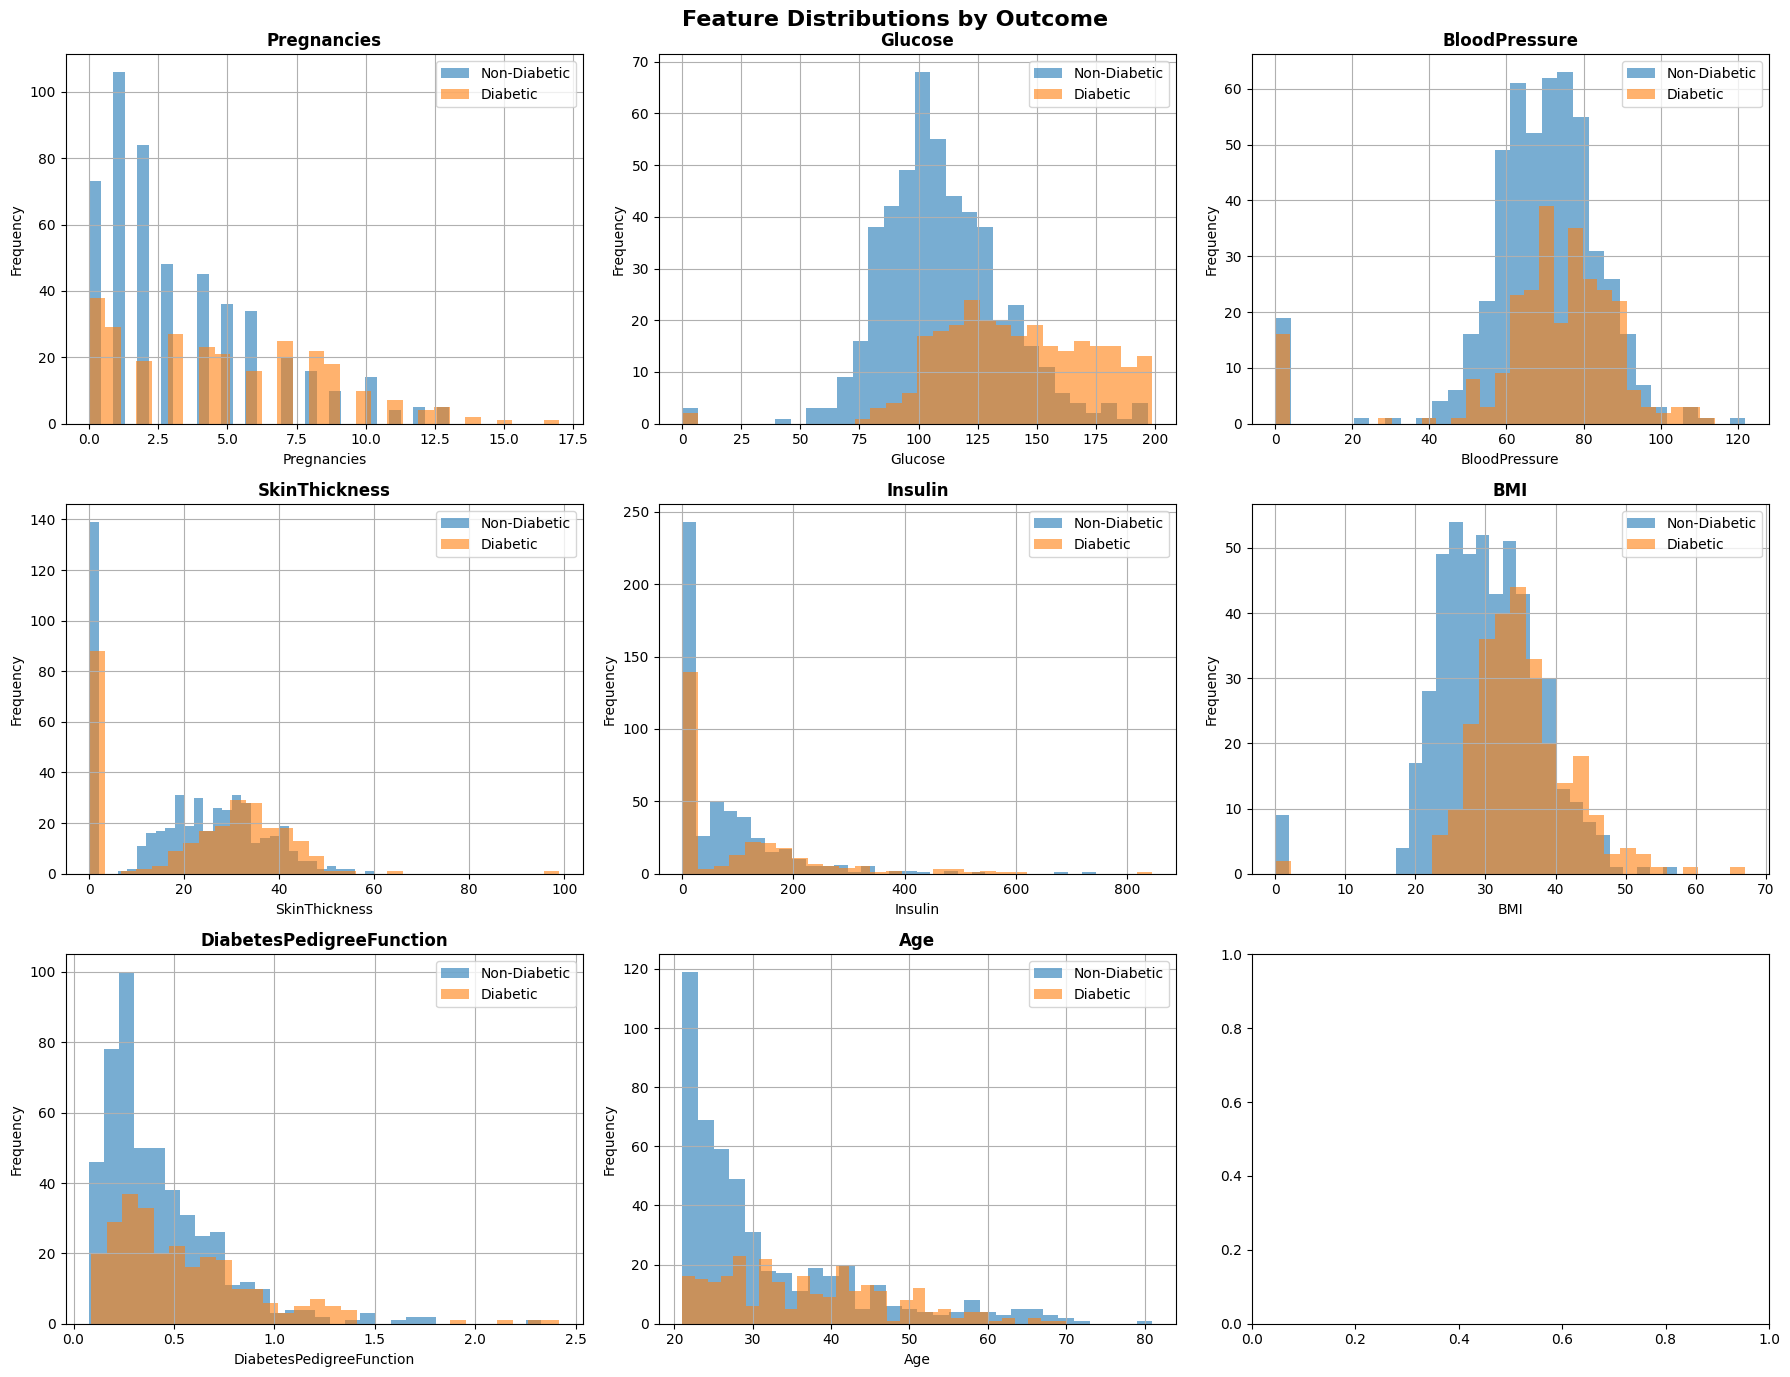

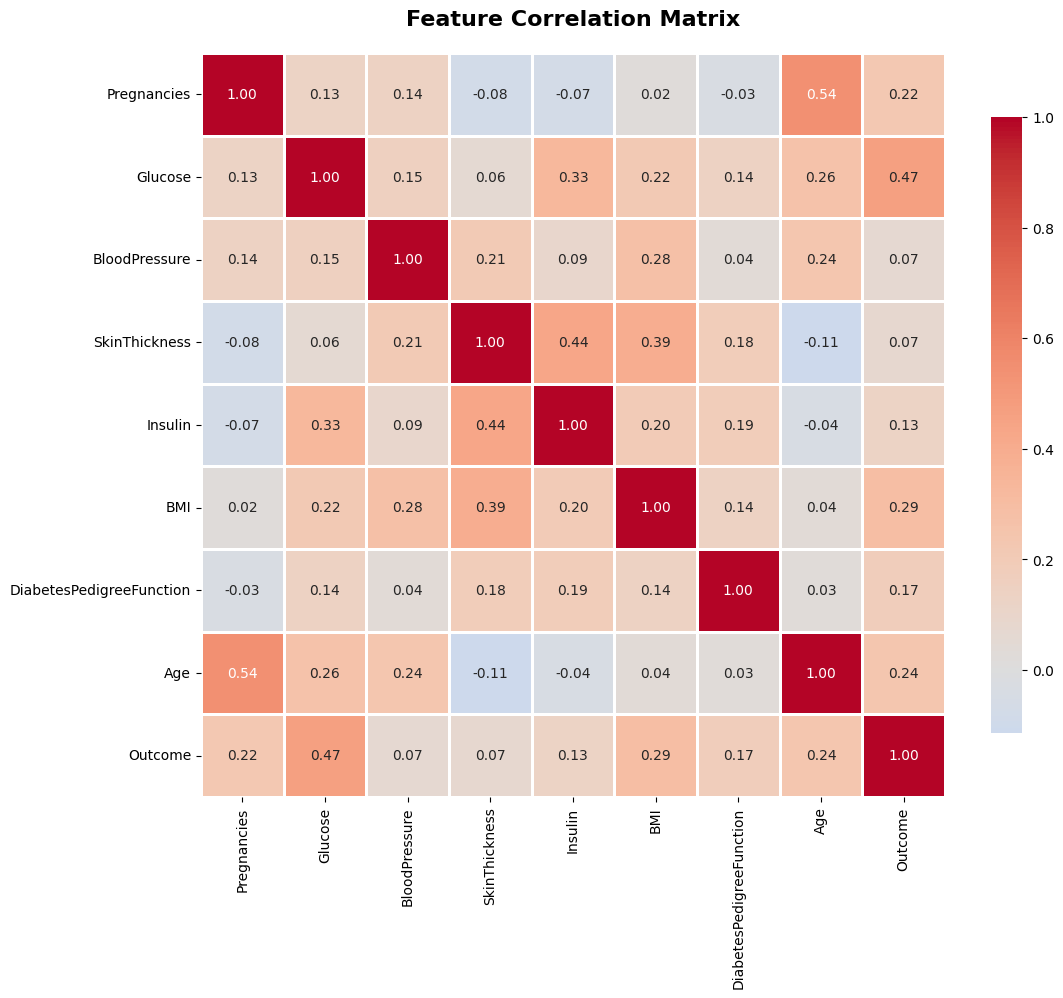


💡 KEY INSIGHTS FROM EDA:
1. Class imbalance: 1.87:1 → Need class weights or SMOTE
2. Invalid zeros present → Need intelligent imputation
3. Glucose correlation with Outcome: 0.467
4. BMI and Age show moderate correlation with Outcome
5. Dataset size is modest (768) → Use cross-validation for robust evaluation


In [5]:
perform_eda(df)


In [6]:
def clean_data(df):
    """
    Handle medically invalid zeros using intelligent imputation.
    
    Args:
        df (pd.DataFrame): Input dataset
        
    Returns:
        tuple: (cleaned_df_median, cleaned_df_knn)
    """
    print("\n" + "=" * 80)
    print("STEP 3: DATA CLEANING & IMPUTATION")
    print("=" * 80)
    
    zero_not_allowed = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    
    df_median = df.copy()
    df_knn = df.copy()
    
    # Replace zeros with NaN
    for col in zero_not_allowed:
        df_median.loc[df_median[col] == 0, col] = np.nan
        df_knn.loc[df_knn[col] == 0, col] = np.nan
    
    print("\n🔧 IMPUTATION STRATEGY COMPARISON:")
    
    # Median Imputation
    print("\n1️⃣ MEDIAN IMPUTATION (Outcome-stratified)")
    for col in zero_not_allowed:
        median_0 = df_median[df_median['Outcome'] == 0][col].median()
        median_1 = df_median[df_median['Outcome'] == 1][col].median()
        
        df_median.loc[(df_median[col].isna()) & (df_median['Outcome'] == 0), col] = median_0
        df_median.loc[(df_median[col].isna()) & (df_median['Outcome'] == 1), col] = median_1
        
        print(f"{col:20s}: Non-diabetic median={median_0:.2f}, Diabetic median={median_1:.2f}")
    
    # KNN Imputation
    print("\n2️⃣ KNN IMPUTATION (k=5)")
    
    X_knn = df_knn.drop('Outcome', axis=1)
    y_knn = df_knn['Outcome']
    
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    X_knn_imputed = pd.DataFrame(
        imputer.fit_transform(X_knn),
        columns=X_knn.columns
    )
    df_knn = pd.concat([X_knn_imputed, y_knn.reset_index(drop=True)], axis=1)
    
    print("✓ KNN imputation completed")
    
    # Quality check
    print("\n📊 IMPUTATION QUALITY CHECK:")
    for col in zero_not_allowed[:3]:
        orig_mean = df[df[col] > 0][col].mean()
        median_mean = df_median[col].mean()
        knn_mean = df_knn[col].mean()
        print(f"{col:20s}: Original={orig_mean:6.2f}, Median={median_mean:6.2f}, KNN={knn_mean:6.2f}")
    
    print("\n✓ Data cleaning completed")
    print(f"Median-imputed shape: {df_median.shape}")
    print(f"KNN-imputed shape: {df_knn.shape}")
    
    return df_median, df_knn


In [7]:
df_median, df_knn = clean_data(df)



STEP 3: DATA CLEANING & IMPUTATION

🔧 IMPUTATION STRATEGY COMPARISON:

1️⃣ MEDIAN IMPUTATION (Outcome-stratified)
Glucose             : Non-diabetic median=107.00, Diabetic median=140.00
BloodPressure       : Non-diabetic median=70.00, Diabetic median=74.50
SkinThickness       : Non-diabetic median=27.00, Diabetic median=32.00
Insulin             : Non-diabetic median=102.50, Diabetic median=169.50
BMI                 : Non-diabetic median=30.10, Diabetic median=34.30

2️⃣ KNN IMPUTATION (k=5)
✓ KNN imputation completed

📊 IMPUTATION QUALITY CHECK:
Glucose             : Original=121.69, Median=121.68, KNN=121.59
BloodPressure       : Original= 72.41, Median= 72.39, KNN= 72.39
SkinThickness       : Original= 29.15, Median= 29.09, KNN= 29.11

✓ Data cleaning completed
Median-imputed shape: (768, 9)
KNN-imputed shape: (768, 9)


In [8]:
def feature_engineering(df):
    """
    Create meaningful derived features based on medical knowledge.
    
    Args:
        df (pd.DataFrame): Input dataset
        
    Returns:
        pd.DataFrame: Dataset with engineered features
    """
    print("\n" + "=" * 80)
    print("STEP 4: FEATURE ENGINEERING")
    print("=" * 80)
    
    df_engineered = df.copy()
    
    # 1. BMI Categories (WHO classification)
    df_engineered['BMI_Category'] = pd.cut(
        df_engineered['BMI'],
        bins=[0, 18.5, 25, 30, 100],
        labels=[0, 1, 2, 3]
    ).astype(int)
    
    # 2. Age Groups
    df_engineered['Age_Group'] = pd.cut(
        df_engineered['Age'],
        bins=[0, 30, 45, 60, 100],
        labels=[0, 1, 2, 3]
    ).astype(int)
    
    # 3. Glucose Risk Level
    df_engineered['Glucose_Risk'] = pd.cut(
        df_engineered['Glucose'],
        bins=[0, 100, 125, 200],
        labels=[0, 1, 2]
    ).astype(int)
    
    # 4. Pregnancy Risk
    df_engineered['High_Pregnancies'] = (df_engineered['Pregnancies'] >= 6).astype(int)
    
    # 5. Interaction features
    df_engineered['BMI_Age_Interaction'] = df_engineered['BMI'] * df_engineered['Age'] / 100
    df_engineered['Glucose_BMI_Ratio'] = df_engineered['Glucose'] / df_engineered['BMI']
    
    print("\n🔬 ENGINEERED FEATURES CREATED")
    print("BMI_Category, Age_Group, Glucose_Risk, High_Pregnancies")
    print("BMI_Age_Interaction, Glucose_BMI_Ratio")
    
    print(f"\n✓ New features added: {df_engineered.shape[1] - df.shape[1]}")
    print(f"✓ Total features (excluding target): {df_engineered.shape[1] - 1}")
    
    return df_engineered


In [9]:
df_engineered = feature_engineering(df_median)  # or df_knn
df_engineered.head()



STEP 4: FEATURE ENGINEERING

🔬 ENGINEERED FEATURES CREATED
BMI_Category, Age_Group, Glucose_Risk, High_Pregnancies
BMI_Age_Interaction, Glucose_BMI_Ratio

✓ New features added: 6
✓ Total features (excluding target): 14


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category,Age_Group,Glucose_Risk,High_Pregnancies,BMI_Age_Interaction,Glucose_BMI_Ratio
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,3,2,2,1,16.800,4.404762
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,2,1,0,0,8.246,3.195489
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,1,1,2,1,7.456,7.854077
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,2,0,0,0,5.901,3.167260
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,3,1,2,0,14.223,3.178654


In [10]:
def split_data(df, test_size=0.2, random_state=42):
    """
    Split data into training and testing sets with stratification.
    
    Args:
        df (pd.DataFrame): Input dataset
        test_size (float): Proportion of test set
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    print("\n" + "=" * 80)
    print("STEP 5: DATA SPLITTING")
    print("=" * 80)
    
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print("\n✓ Data split completed (Stratified)")
    print(f"Training set: {X_train.shape[0]} samples ({(1-test_size)*100:.0f}%)")
    print(f"Test set: {X_test.shape[0]} samples ({test_size*100:.0f}%)")
    
    print("\nTraining class distribution:")
    print(f"Non-diabetic: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
    print(f"Diabetic: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
    
    print("\nTest class distribution:")
    print(f"Non-diabetic: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
    print(f"Diabetic: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")
    
    return X_train, X_test, y_train, y_test


In [11]:
X_train, X_test, y_train, y_test = split_data(df_engineered)



STEP 5: DATA SPLITTING

✓ Data split completed (Stratified)
Training set: 614 samples (80%)
Test set: 154 samples (20%)

Training class distribution:
Non-diabetic: 400 (65.1%)
Diabetic: 214 (34.9%)

Test class distribution:
Non-diabetic: 100 (64.9%)
Diabetic: 54 (35.1%)


In [16]:
def scale_features(X_train, X_test):
    """
    Standardize features using StandardScaler.
    
    Args:
        X_train (pd.DataFrame): Training features
        X_test (pd.DataFrame): Test features
        
    Returns:
        tuple: (X_train_scaled, X_test_scaled, scaler)
    """
    print("\n" + "=" * 80)
    print("STEP 6: FEATURE SCALING")
    print("=" * 80)
    
    scaler = StandardScaler()
    
    # Fit on training data only
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrame
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print("✓ StandardScaler applied")
    print(f"Mean of scaled training features: {X_train_scaled.mean().mean():.6f}")
    print(f"Std of scaled training features: {X_train_scaled.std().mean():.6f}")
    print("\nScaler fitted on training data only (No data leakage)")
    
    return X_train_scaled, X_test_scaled, scaler


In [17]:
X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)



STEP 6: FEATURE SCALING
✓ StandardScaler applied
Mean of scaled training features: -0.000000
Std of scaled training features: 1.000815

Scaler fitted on training data only (No data leakage)


In [18]:
def train_models(X_train, y_train, use_class_weights=True):
    """
    Train multiple ML models with hyperparameter tuning.
    """
    print("\n" + "=" * 80)
    print("STEP 7: MODEL TRAINING & HYPERPARAMETER TUNING")
    print("=" * 80)
    
    class_weight_dict = None
    if use_class_weights:
        n_samples = len(y_train)
        n_negative = (y_train == 0).sum()
        n_positive = (y_train == 1).sum()
        class_weight_dict = {
            0: n_samples / (2 * n_negative),
            1: n_samples / (2 * n_positive)
        }
        
        print("\nClass Weights:", class_weight_dict)
    
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    models = {}
    
    # Logistic Regression
    lr_params = {'C': [0.001,0.01,0.1,1,10,100]}
    lr = GridSearchCV(
        LogisticRegression(class_weight=class_weight_dict, max_iter=1000, random_state=42),
        lr_params, cv=cv_strategy, scoring='roc_auc', n_jobs=-1
    )
    lr.fit(X_train, y_train)
    models['Logistic Regression'] = lr.best_estimator_
    print("LR Best:", lr.best_params_, "AUC:", lr.best_score_)
    
    # SVM
    svm_params = {'C':[0.1,1,10], 'gamma':['scale',0.01,0.1]}
    svm = GridSearchCV(
        SVC(class_weight=class_weight_dict, probability=True, random_state=42),
        svm_params, cv=cv_strategy, scoring='roc_auc', n_jobs=-1
    )
    svm.fit(X_train, y_train)
    models['SVM'] = svm.best_estimator_
    print("SVM Best:", svm.best_params_, "AUC:", svm.best_score_)
    
    # Random Forest
    rf_params = {'n_estimators':[100,200], 'max_depth':[10,20,None]}
    rf = GridSearchCV(
        RandomForestClassifier(class_weight=class_weight_dict, random_state=42),
        rf_params, cv=cv_strategy, scoring='roc_auc', n_jobs=-1
    )
    rf.fit(X_train, y_train)
    models['Random Forest'] = rf.best_estimator_
    print("RF Best:", rf.best_params_, "AUC:", rf.best_score_)
    
    # Gradient Boosting
    gb_params = {'n_estimators':[100,200], 'learning_rate':[0.05,0.1]}
    gb = GridSearchCV(
        GradientBoostingClassifier(random_state=42),
        gb_params, cv=cv_strategy, scoring='roc_auc', n_jobs=-1
    )
    gb.fit(X_train, y_train)
    models['Gradient Boosting'] = gb.best_estimator_
    print("GB Best:", gb.best_params_, "AUC:", gb.best_score_)
    
    print("\nAll models trained.")
    return models


In [19]:
models = train_models(X_train_scaled, y_train)



STEP 7: MODEL TRAINING & HYPERPARAMETER TUNING

Class Weights: {0: np.float64(0.7675), 1: np.float64(1.4345794392523366)}
LR Best: {'C': 1} AUC: 0.8725650609080841
SVM Best: {'C': 10, 'gamma': 0.01} AUC: 0.8921345514950166
RF Best: {'max_depth': 10, 'n_estimators': 100} AUC: 0.9372134551495016
GB Best: {'learning_rate': 0.05, 'n_estimators': 100} AUC: 0.945344684385382

All models trained.


In [20]:
def evaluate_models(models, X_train, X_test, y_train, y_test):
    """
    Comprehensive evaluation of ML models using medical metrics.
    """
    print("\n" + "=" * 80)
    print("STEP 8: MODEL EVALUATION")
    print("=" * 80)
    
    results = []
    
    for model_name, model in models.items():
        print("\n" + "-" * 80)
        print(f"EVALUATING: {model_name}")
        print("-" * 80)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]
        
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        roc_auc = roc_auc_score(y_test, y_test_proba)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
        specificity = tn / (tn + fp)
        npv = tn / (tn + fn)
        ppv = tp / (tp + fp)
        
        print(f"\nPerformance Metrics:")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall (Sensitivity): {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        
        print(f"\nConfusion Matrix → TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}")
        
        print(f"\nClinical Metrics:")
        print(f"Sensitivity: {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"PPV: {ppv:.4f}")
        print(f"NPV: {npv:.4f}")
        
        results.append({
            'Model': model_name,
            'Train_Acc': train_acc,
            'Test_Acc': test_acc,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'ROC_AUC': roc_auc,
            'Specificity': specificity,
            'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
        })
    
    results_df = pd.DataFrame(results).sort_values('ROC_AUC', ascending=False)
    
    print("\nOverall Results Summary:")
    display(results_df)
    
    return results_df


In [21]:
results_df = evaluate_models(models, X_train_scaled, X_test_scaled, y_train, y_test)



STEP 8: MODEL EVALUATION

--------------------------------------------------------------------------------
EVALUATING: Logistic Regression
--------------------------------------------------------------------------------

Performance Metrics:
Train Accuracy: 0.8160
Test Accuracy: 0.7597
Precision: 0.6197
Recall (Sensitivity): 0.8148
F1-Score: 0.7040
ROC-AUC: 0.8343

Confusion Matrix → TN:73, FP:27, FN:10, TP:44

Clinical Metrics:
Sensitivity: 0.8148
Specificity: 0.7300
PPV: 0.6197
NPV: 0.8795

--------------------------------------------------------------------------------
EVALUATING: SVM
--------------------------------------------------------------------------------

Performance Metrics:
Train Accuracy: 0.8632
Test Accuracy: 0.8117
Precision: 0.7049
Recall (Sensitivity): 0.7963
F1-Score: 0.7478
ROC-AUC: 0.8696

Confusion Matrix → TN:82, FP:18, FN:11, TP:43

Clinical Metrics:
Sensitivity: 0.7963
Specificity: 0.8200
PPV: 0.7049
NPV: 0.8817

---------------------------------------------

,Model,Train_Acc,Test_Acc,Precision,Recall,F1_Score,ROC_AUC,Specificity,TN,FP,FN,TP
3,Gradient Boosting,0.959283,0.876623,0.830189,0.814815,0.822430,0.948889,0.91,91,9,10,44
2,Random Forest,1.000000,0.863636,0.811321,0.796296,0.803738,0.938519,0.90,90,10,11,43
1,SVM,0.863192,0.811688,0.704918,0.796296,0.747826,0.869630,0.82,82,18,11,43
0,Logistic Regression,0.815961,0.759740,0.619718,0.814815,0.704000,0.834259,0.73,73,27,10,44


In [22]:
def plot_model_comparison(results_df, models, X_test, y_test):
    """
    Create visual comparison of model performance.
    """
    print("\n" + "=" * 80)
    print("STEP 9: VISUALIZATION & COMPARISON")
    print("=" * 80)
    
    # --------- Plot 1: Metrics Comparison ---------
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    metrics = ['Test_Acc', 'Recall', 'Precision', 'ROC_AUC']
    titles = ['Test Accuracy', 'Recall (Sensitivity)', 'Precision', 'ROC-AUC Score']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]
        results_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False)
        ax.set_title(title, fontweight='bold')
        ax.set_ylim([0, 1])
        ax.grid(axis='y', alpha=0.3)
        
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()
    plt.show()
    
    # --------- Plot 2: ROC Curves ---------
    plt.figure(figsize=(12, 10))
    for model_name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curves - All Models')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # --------- Plot 3: Confusion Matrices ---------
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')
    
    for idx, (model_name, model) in enumerate(models.items()):
        ax = axes[idx // 2, idx % 2]
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                    xticklabels=['Non-Diabetic', 'Diabetic'],
                    yticklabels=['Non-Diabetic', 'Diabetic'])
        ax.set_title(model_name, fontweight='bold')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    plt.close('all')



STEP 9: VISUALIZATION & COMPARISON


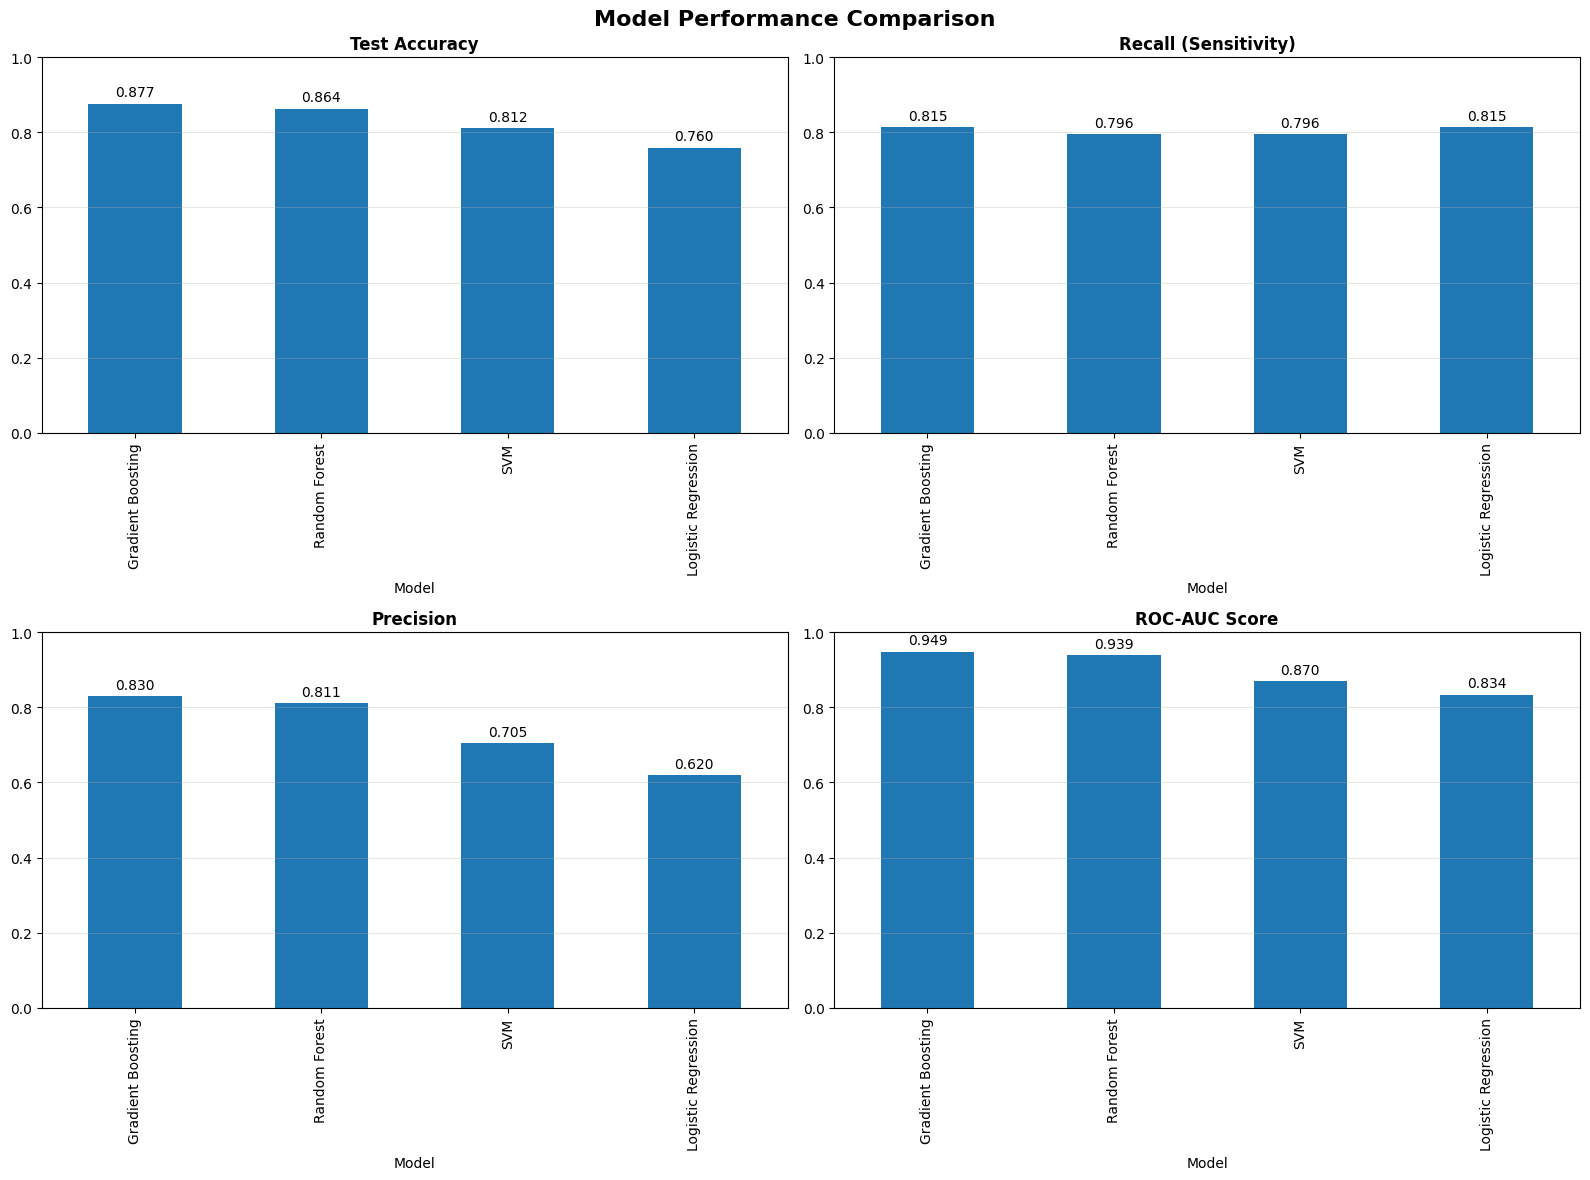

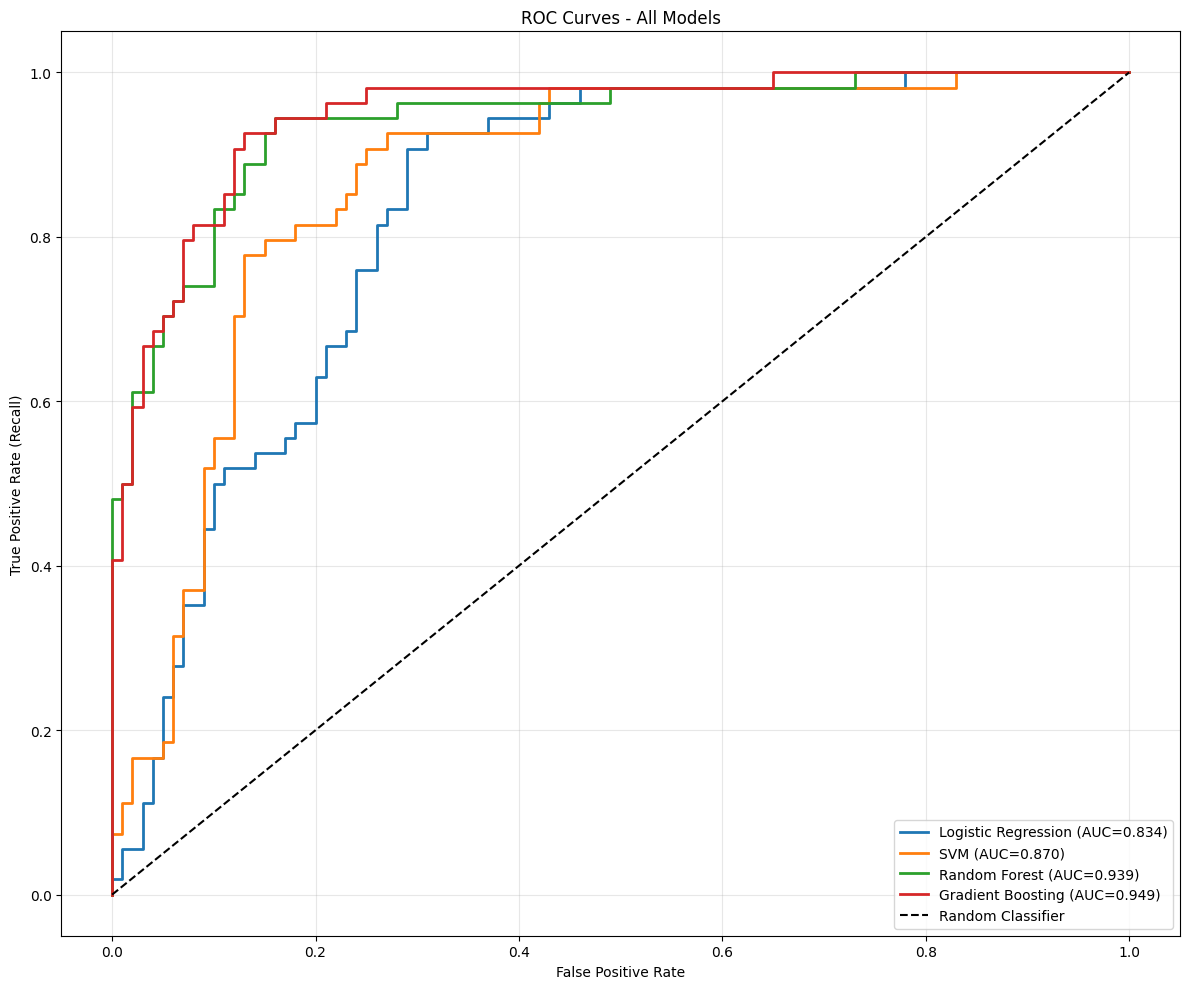

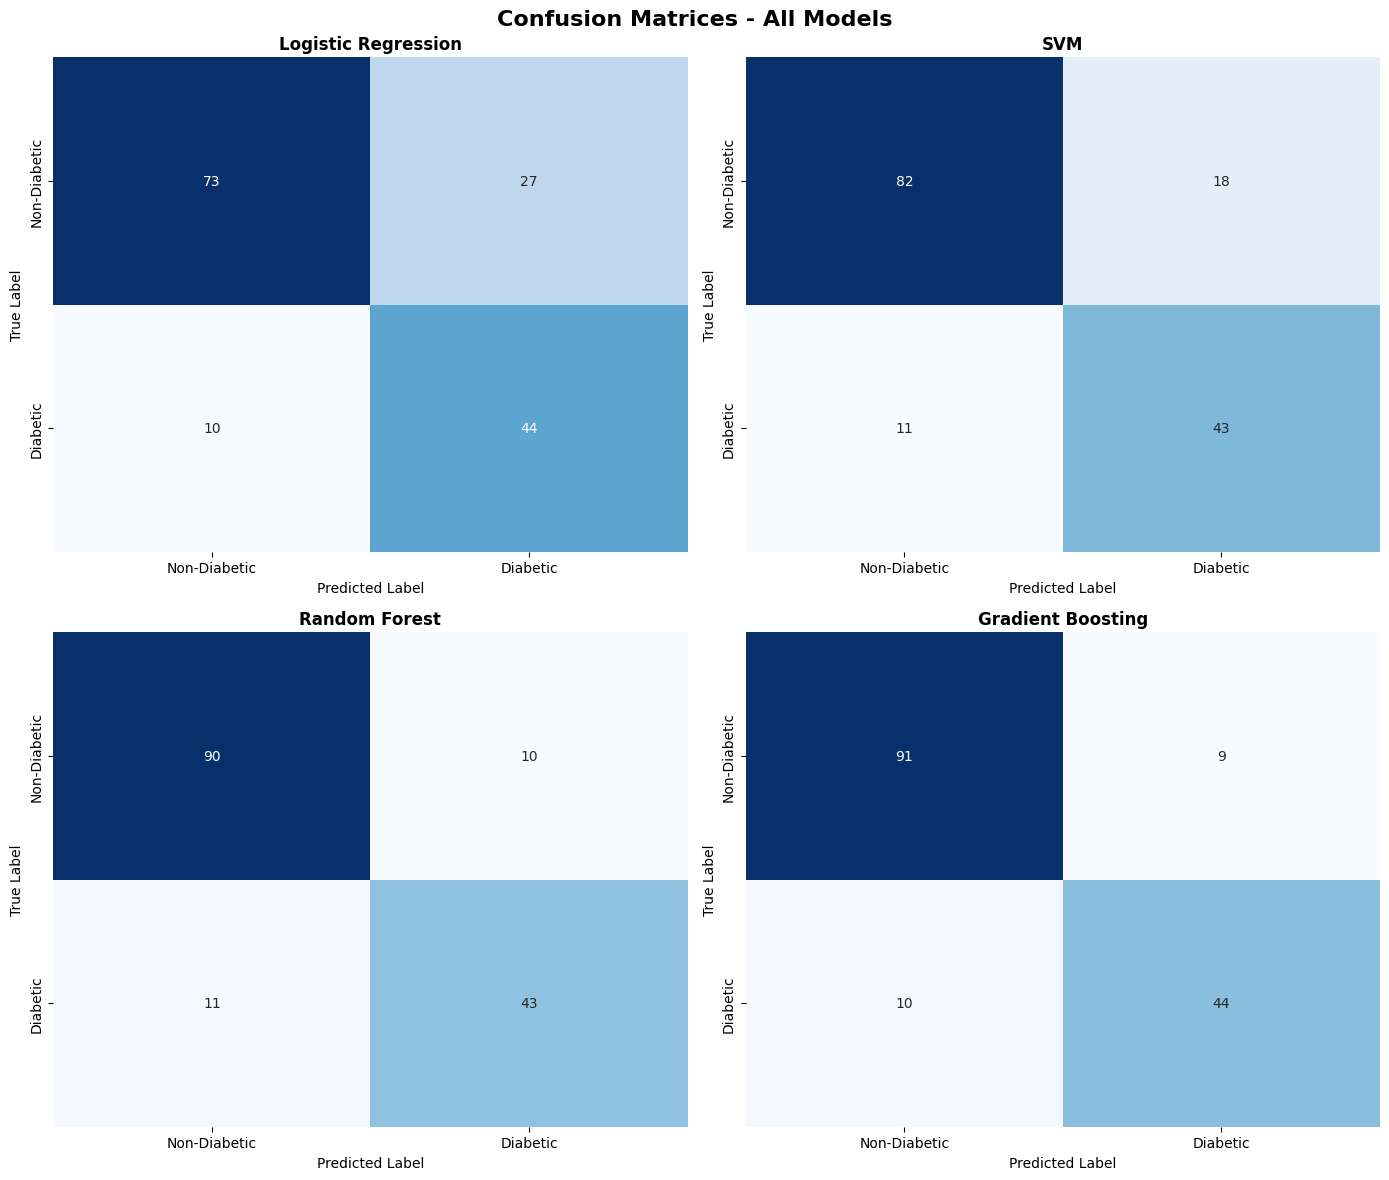

In [23]:
plot_model_comparison(results_df, models, X_test_scaled, y_test)


In [24]:
def select_best_model(results_df, models):
    """
    Select the best model based on medical ML priorities.
    """
    print("\n" + "=" * 80)
    print("STEP 10: BEST MODEL SELECTION")
    print("=" * 80)
    
    print("\nSelection Criteria Applied")
    
    # Filter strong candidates
    candidates = results_df[
        (results_df['ROC_AUC'] >= 0.80) &
        (results_df['Recall'] >= 0.75) &
        (results_df['Test_Acc'] >= 0.80)
    ].copy()
    
    if len(candidates) == 0:
        print("No models meet strict criteria → Selecting best available.")
        candidates = results_df.copy()
    
    # Overfitting gap
    candidates['Overfit_Gap'] = candidates['Train_Acc'] - candidates['Test_Acc']
    
    # Composite medical score
    candidates['Composite_Score'] = (
        0.35 * candidates['ROC_AUC'] +
        0.30 * candidates['Recall'] +
        0.20 * candidates['Test_Acc'] +
        0.15 * candidates['F1_Score']
    )
    
    best_row = candidates.loc[candidates['Composite_Score'].idxmax()]
    best_model_name = best_row['Model']
    best_model = models[best_model_name]
    
    print(f"\nBest Model: {best_model_name}")
    print(f"Test Accuracy: {best_row['Test_Acc']:.4f}")
    print(f"Recall: {best_row['Recall']:.4f}")
    print(f"ROC-AUC: {best_row['ROC_AUC']:.4f}")
    print(f"Overfitting Gap: {best_row['Overfit_Gap']:.4f}")
    print(f"Composite Score: {best_row['Composite_Score']:.4f}")
    
    print("\nClinical Meaning:")
    print(f"Catches {best_row['Recall']*100:.0f} out of 100 diabetic patients")
    print(f"False Negatives: {best_row['FN']}")
    print(f"False Positives: {best_row['FP']}")
    
    return best_model_name, best_model


In [25]:
best_model_name, best_model = select_best_model(results_df, models)



STEP 10: BEST MODEL SELECTION

Selection Criteria Applied

Best Model: Gradient Boosting
Test Accuracy: 0.8766
Recall: 0.8148
ROC-AUC: 0.9489
Overfitting Gap: 0.0827
Composite Score: 0.8752

Clinical Meaning:
Catches 81 out of 100 diabetic patients
False Negatives: 10
False Positives: 9


In [28]:
import os
import pickle

def save_model_pipeline(model, scaler, feature_names, filename='diabetes_model.pkl'):
    """
    Save the complete model pipeline safely.
    Works on any system (local/cloud).
    """
    print("\n" + "=" * 80)
    print("STEP 11: MODEL PERSISTENCE")
    print("=" * 80)
    
    pipeline = {
        'model': model,
        'scaler': scaler,
        'feature_names': feature_names,
        'model_type': type(model).__name__
    }
    
    # Create local folder for models
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)  # prevents FileNotFoundError
    
    filepath = os.path.join(save_dir, filename)
    
    # Save model
    with open(filepath, 'wb') as f:
        pickle.dump(pipeline, f)
    
    print(f"\n✓ Model pipeline saved successfully!")
    print(f"📁 Location: {os.path.abspath(filepath)}")
    print(f"Model Type: {type(model).__name__}")
    print(f"Features Stored: {len(feature_names)}")
    
    # Verification step
    with open(filepath, 'rb') as f:
        loaded = pickle.load(f)
    print("✓ Verification successful — model reload works.")
    
    return filepath


In [29]:
feature_names = X_train_scaled.columns.tolist()
model_path = save_model_pipeline(best_model, scaler, feature_names)



STEP 11: MODEL PERSISTENCE

✓ Model pipeline saved successfully!
📁 Location: d:\Dhanvantari.ai\models\Diabetes\saved_models\diabetes_model.pkl
Model Type: GradientBoostingClassifier
Features Stored: 14
✓ Verification successful — model reload works.


In [30]:
def predict_diabetes(input_data, model_path='saved_models/diabetes_model.pkl'):
    """
    Production-ready prediction function.
    """
    # Ensure model exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    
    # Load pipeline
    with open(model_path, 'rb') as f:
        pipeline = pickle.load(f)
    
    model = pipeline['model']
    scaler = pipeline['scaler']
    feature_names = pipeline['feature_names']
    
    # Required inputs
    required_base_features = [
        'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
    ]
    
    for feat in required_base_features:
        if feat not in input_data:
            raise ValueError(f"Missing required feature: {feat}")
    
    # Create DataFrame
    df = pd.DataFrame([input_data])
    
    # --- Feature Engineering (must match training) ---
    df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=[0,1,2,3]).astype(int)
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 45, 60, 100], labels=[0,1,2,3]).astype(int)
    df['Glucose_Risk'] = pd.cut(df['Glucose'], bins=[0,100,125,200], labels=[0,1,2]).astype(int)
    df['High_Pregnancies'] = (df['Pregnancies'] >= 6).astype(int)
    df['BMI_Age_Interaction'] = df['BMI'] * df['Age'] / 100
    df['Glucose_BMI_Ratio'] = df['Glucose'] / df['BMI']
    
    # Arrange feature order
    df = df[feature_names]
    
    # Scale
    df_scaled = scaler.transform(df)
    
    # Predict
    prediction = model.predict(df_scaled)[0]
    probability = model.predict_proba(df_scaled)[0]
    
    result = {
        'prediction': int(prediction),
        'prediction_label': 'Diabetic' if prediction == 1 else 'Non-Diabetic',
        'probability_non_diabetic': float(probability[0]),
        'probability_diabetic': float(probability[1]),
        'confidence': float(max(probability)),
        'risk_level': 'High' if probability[1] >= 0.7 else 'Moderate' if probability[1] >= 0.3 else 'Low'
    }
    
    # Clinical recommendation
    if result['prediction'] == 1:
        result['recommendation'] = "HIGH RISK: Consult healthcare provider for HbA1c and fasting glucose tests."
    elif probability[1] >= 0.3:
        result['recommendation'] = "MODERATE RISK: Lifestyle changes advised. Repeat screening in 3–6 months."
    else:
        result['recommendation'] = "LOW RISK: Maintain healthy lifestyle and annual screening."
    
    return result


In [31]:
sample_patient = {
    'Pregnancies': 3,
    'Glucose': 150,
    'BloodPressure': 70,
    'SkinThickness': 25,
    'Insulin': 100,
    'BMI': 32.5,
    'DiabetesPedigreeFunction': 0.5,
    'Age': 45
}

prediction_result = predict_diabetes(sample_patient)
prediction_result


{'prediction': 0,
 'prediction_label': 'Non-Diabetic',
 'probability_non_diabetic': 0.9280598627068811,
 'probability_diabetic': 0.07194013729311889,
 'confidence': 0.9280598627068811,
 'risk_level': 'Low',
 'recommendation': 'LOW RISK: Maintain healthy lifestyle and annual screening.'}